# Roofline Analysis of the Fused Layers

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

from collections import OrderedDict

## Bottleneck Layer

In [119]:
# configuration
H, W, C1, C2, F, K = 28, 28, 256, 64, 256, 3
max_DSP = 1963 # one DSP can perform 2 multiplications
FREQ = 200

In [120]:
# pointwise compute roof
conv_roof = max_DSP * 2 * FREQ * 1e-3
wino_roof = max_DSP * 2 * ((K ** 2) * 16 / 36) * FREQ * 1e-3
conv_roof, wino_roof

(785.2, 3140.8)

In [121]:
def solve(f, max_DSP):
    p_star = 0.0
    DSP_star = None
    for x in np.arange(max_DSP + 1):
        for y in np.arange(max_DSP + 1 - x):
            z = max_DSP - x - y
            if x > 0 and y > 0 and z > 0:
                p = f([x, y, z])
                if p > p_star:
                    p_star = p
                    DSP_star = [x, y, z]
    return p_star * 1e-9, DSP_star

### Bottleneck

In [122]:
%%time
# fused conventional roof
f = lambda DSP: ((2 * H * W * (C1 * C2 + C2 * C2 * K * K + C2 * F)) / 
                 (((H * W * C1 * C2) / DSP[0] +
                   (H * W * C2 * C2 * K * K) / DSP[1] +
                   (H * W * C2 * F) / DSP[2]) * (1./FREQ * 1e-6)))
print(solve(f, max_DSP * 2))

(544.8326059268065, [1122, 1682, 1122])
CPU times: user 14.6 s, sys: 3.63 ms, total: 14.6 s
Wall time: 14.6 s


In [123]:
%%time
# fused winograd roof
f = lambda DSP: ((2 * H * W * (C1 * C2 + C2 * C2 * K * K + C2 * F)) / 
                 (max((H * W * C1 * C2) / DSP[0],
                      (H * W * C2 * C2 * 2.25) / DSP[1],
                      (H * W * C2 * F) / DSP[2]) * (1./FREQ * 1e-6)))
print(solve(f, max_DSP * 2))

(2604.3999999999996, [1532, 862, 1532])
CPU times: user 30.7 s, sys: 0 ns, total: 30.7 s
Wall time: 30.7 s


In [124]:
wino_blk_roof = (((2 * H * W * (C1 * C2 + C2 * C2 * K * K + C2 * F)) /
                  (H * W * (C1 * C2 + C2 * C2 * 2.25 + C2 * F))) * max_DSP * 2 * FREQ * 1e-3)
wino_blk_roof

2604.5658536585365

### Depthwise Separable

In [125]:
%%time
# fused conventional roof
f = lambda DSP: ((2 * H * W * (C2 * K * K + C2 * C1)) / 
                 (max((H * W * C1 * C2) / DSP[1],
                      (H * W * C2 * 2.25) / DSP[0]) * (1./FREQ * 1e-6)))
print(solve(f, max_DSP * 2))

(1610.7031249999998, [35, 3890, 1])
CPU times: user 27.2 s, sys: 3.03 ms, total: 27.2 s
Wall time: 27.2 s


In [126]:
wino_blk_roof = (((2 * H * W * (C1 * C2 + C2 * K * K)) /
                  (H * W * (C1 * C2 + C2 * 2.25))) * max_DSP * 2 * FREQ * 1e-3)
wino_blk_roof

1611.4462729912873

### Separable Bottleneck

In [127]:
%%time
f = lambda DSP: ((2 * H * W * (C1 * C2 + C2 * K * K + C2 * F)) / 
                 (max((H * W * C1 * C2) / DSP[0],
                      (H * W * C2 * 2.25) / DSP[1],
                      (H * W * C2 * F) / DSP[2]) * (1./FREQ * 1e-6)))
print(solve(f, max_DSP * 2))

(1590.6781250000001, [1954, 18, 1954])
CPU times: user 30 s, sys: 0 ns, total: 30 s
Wall time: 30 s


In [128]:
wino_blk_roof = (((2 * H * W * (C1 * C2 + C2 * K * K + C2 * F)) /
                  (H * W * (C1 * C2 + C2 * 2.25 + C2 * F))) * max_DSP * 2 * FREQ * 1e-3)
wino_blk_roof

1591.0129314535732

In [129]:
# CTC of not fused
CTC = OrderedDict({
    'pointwise': ((2 * H * W * C1 * C2) /
                  ((H * W * (C1 + C2) + C1 * C2) * 2)),
    'standard': ((2 * H * W * C2 * C2 * K * K) /
                 ((H * W * C2 * 2 + C2 * C2 * K * K) * 2)),
    'depthwise': ((2 * H * W * C2 * K * 2) /
                  ((H * W * C2 * 2 + C2 * K * K) * 2)),
    
    # depthwise separable
    'dwsp_orig': ((2 * H * W * (C2 * K * K + C2 * C1)) /
                  (((2 * H * W * C2 + C2 * K * K) +
                    (H * W * (C1 + C2) + C1 * C2)) * 2)),
    'dwsp_fuse': ((2 * H * W * (C2 * K * K + C2 * C1)) /
                  ((H * W * (C1 + C2) + C2 * K * K + C1 * C2) * 2)),
    
    # bottlenecks
    'btnk_orig': ((2 * H * W * (C1 * C2 + C2 * C2 * K * K + C2 * F)) /
                  (((H * W * (C1 + C2) + C1 * C2) +
                    (2 * H * W * C2 + K * K * C2 * C2) +
                    (H * W * (C2 + F) + C2 * F)) * 2)),
    'btnk_fuse': ((2 * H * W * (C1 * C2 + C2 * C2 * K * K + C2 * F)) /
                  (((H * W * (C1 + F) + 
                    C1 * C2 + K * K * C2 * C2 + C2 * F)) * 2)),
    
    # separable bottleneck
    'spnk_orig': ((2 * H * W * (C1 * C2 + C2 * K * K + C2 * F)) /
                  (((H * W * (C1 + C2) + C1 * C2) +
                    (2 * H * W * C2 + K * K * C2) +
                    (H * W * (C2 + F) + C2 * F)) * 2)),
    'spnk_fuse': ((2 * H * W * (C1 * C2 + C2 * K * K + C2 * F)) /
                  ((H * W * (C1 + F) + 
                    C1 * C2 + K * K * C2 + C2 * F) * 2))
})

CTC

OrderedDict([('pointwise', 48.06130268199234),
             ('standard', 210.62686567164178),
             ('depthwise', 2.98287888395688),
             ('dwsp_orig', 36.113332174517645),
             ('dwsp_fuse', 49.643966547192356),
             ('btnk_orig', 81.26829268292683),
             ('btnk_fuse', 115.89565217391305),
             ('spnk_orig', 41.13848323093967),
             ('spnk_fuse', 60.130133961430886)])

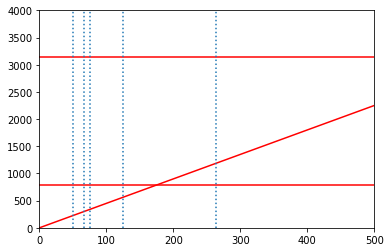

In [130]:
fig, ax = plt.subplots()

ylim = [0, 4000]
xlim = [0, 500]
bandwidth = 4.5
bandwidth_xs = np.arange(xlim[1] + 1)
bandwidth_ys = bandwidth_xs * bandwidth

ax.axhline(conv_roof, color='r')
ax.axhline(wino_roof, color='r')
ax.plot(bandwidth_xs, bandwidth_ys, 'r')
ax.axvline(CTC_orig_blk, linestyle=':')
ax.axvline(CTC_wino_blk, linestyle=':')
ax.axvline(CTC_point, linestyle=':')
ax.axvline(CTC_wino, linestyle=':')
ax.axvline(CTC_conv, linestyle=':')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

fig.savefig('fused_roofline.pdf')